# Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import pickle

# Read Data

In [2]:
data = pd.read_csv('orderbook_dataset')
data.head()

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,price,volume,datetime
0,1,45,272.75,273.15,11,1,272.75,45,2019-08-07 09:02:17 UTC
1,1,45,272.75,273.15,11,1,272.40,45,2019-08-07 09:02:19 UTC
2,1,45,272.75,273.15,11,1,272.25,39,2019-08-07 09:02:20 UTC
3,1,45,272.75,273.15,11,1,271.75,44,2019-08-07 09:02:21 UTC
4,2,284,271.75,272.20,60,1,271.75,72,2019-08-07 09:02:22 UTC


- Data contains 100l rows and 9 columns

In [3]:
data.shape

(100000, 9)

In [4]:
data.describe()

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,price,volume
count,100000.000000,1.000000e+05,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,4.086490,-9.223372e+10,261.894429,261.994726,-9.223372e+10,3.993910,261.948569,97.356650
std,4.244162,2.916686e+13,4.158083,4.162489,2.916686e+13,3.099495,4.075739,2368.185947
min,0.000000,-9.223372e+15,0.000000,0.000000,-9.223372e+15,0.000000,253.200000,1.000000
25%,2.000000,7.700000e+01,259.600000,259.700000,7.000000e+01,2.000000,259.650000,20.000000
50%,3.000000,1.530000e+02,261.500000,261.600000,1.440000e+02,3.000000,261.550000,46.000000
75%,6.000000,2.750000e+02,263.450000,263.550000,2.580000e+02,6.000000,263.500000,88.000000
max,896.000000,3.205000e+03,276.300000,276.350000,3.083000e+03,336.000000,276.300000,263336.000000


- From the description, ask count and volume clearly contain outliers and this outliers can be seen to be the ,ax value of he 2 columns.

- Remove the outliers because they can affect the visual representation of the rest of our data points and can statistically affect other datapoints as well.

In [5]:
data[data['volume'] == 263336.000000 ]

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,price,volume,datetime
95997,3,202,263.15,263.25,71,2,264.1,263336,2019-08-27 17:35:08 UTC


In [6]:
data[data['ask_count'] == 336.000000]

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,price,volume,datetime
46598,896,-9223372036854776,0.0,0.0,-9223372036854776,336,256.4,50,2019-08-16 12:25:09 UTC


In [7]:
data.drop(data[data['volume'] == 263336.000000 ].index, inplace=True)
data.drop(data[data['ask_count'] == 336.000000].index, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99998 entries, 0 to 99999
Data columns (total 9 columns):
bid_count       99998 non-null int64
bid_quantity    99998 non-null int64
bid             99998 non-null float64
ask             99998 non-null float64
ask_quantity    99998 non-null int64
ask_count       99998 non-null int64
price           99998 non-null float64
volume          99998 non-null int64
datetime        99998 non-null object
dtypes: float64(3), int64(5), object(1)
memory usage: 7.6+ MB


- Data info shows that there are no missing value and all the features are either int or floats except for the datetime columns which will have to be converted to datetime.

In [9]:
data['datetime'] = pd.to_datetime(data['datetime'])

Text(0.5, 1.0, 'Time Series of price by date time')

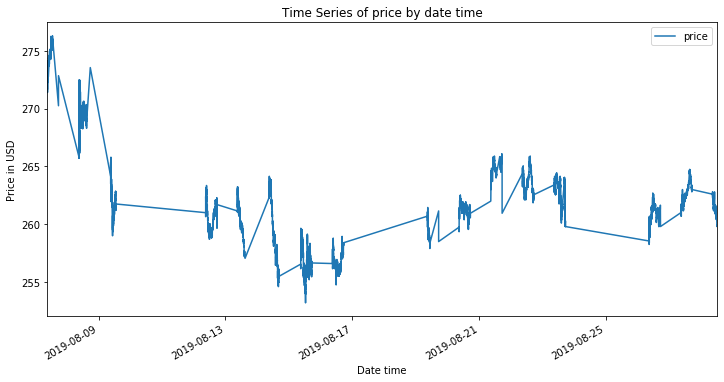

In [10]:
data.plot(x='datetime', y='price', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of price by date time')

- From the plot above, the price for one is not stationary with time, there's also a pattern on the price with time.
- There are occasional upward spikes and sharp falls in price also accompanied by a normal movements.

- To go on with the anomaly detection. Create a new dataframe without the datetime column.

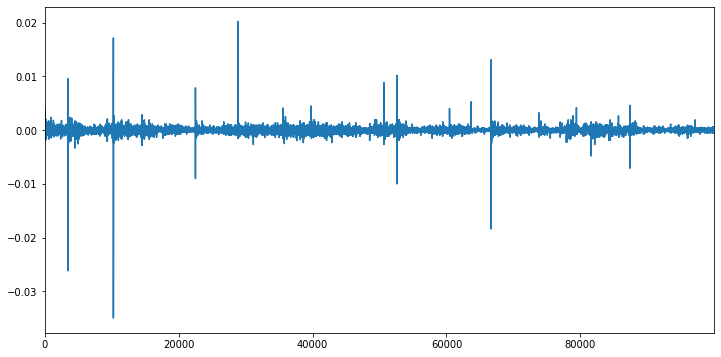

In [11]:
data['price_log'] = np.log(data['price']).diff()
data['price_log'].dropna()
data['price_log'].plot(kind='line', figsize=(12, 6))

In [12]:
#drop datetime and price column
new_data = data.drop(data[['datetime', 'price']], axis=1)

In [13]:
#drop null columns
new_data.dropna(inplace=True)

In [14]:
new_data.head()

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,volume,price_log
1,1,45,272.75,273.15,11,1,45,-0.001284
2,1,45,272.75,273.15,11,1,39,-0.000551
3,1,45,272.75,273.15,11,1,44,-0.001838
4,2,284,271.75,272.20,60,1,72,0.000000
5,2,124,271.75,272.15,27,1,32,0.000000


# Kmeans Cluster
- First an elbow plot to determine the number of clusters to use

In [15]:
sse = {}
# Fit KMeans and calculate SSE for each k
for c in range(1, 10):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=c, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(new_data)
    
    # Assign sum of squared distances to k element of dictionary
    sse[c] = kmeans.inertia_

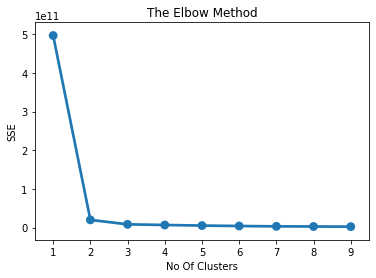

In [16]:
# Plot SSE for each *c*
plt.title('The Elbow Method')
plt.xlabel('No Of Clusters'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

- From the above plot, the number of clusters to use is between 2 and 3. Any one the two numbers can be used.

- Build a Kmeans model with 3 clusters.


In [17]:
X = new_data
X = X.reset_index(drop=True)

knn = KMeans(n_clusters=3)
knn.fit(X)
knn.predict(X)
labels = knn.labels_

- Find the number of components that explains the most variance in the data.

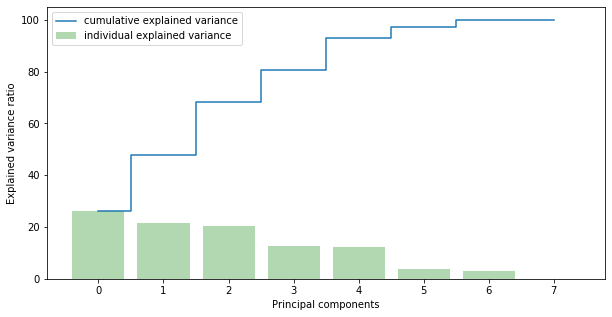

In [18]:
new_df = new_data

#get the values of the data
X = new_df.values
#scale the data using standard scaler
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

#mean vectorizer of the scaled data
mean_vec = np.mean(X_scaled, axis=0)

#covariance matrix, eigen values and vectors
covariance_matrix = np.cov(X_scaled.T)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_pairs = [np.absolute(eigen_values[i], eigen_vectors[:,i]) for i in range(len(eigen_values))]
eigen_pairs.sort(key= lambda x: x[0], reverse=True)

total = sum(eigen_values)

# get the variance explained and cummulative variance explained
variance_explained = [(i/total) * 100 for i in sorted(eigen_values, reverse=True)]
cummulative_variance_explained = np.cumsum(variance_explained)


#plot of the principal components and explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(variance_explained)), variance_explained,
        alpha=0.3, 
        align='center', 
        label='individual explained variance',
        color = 'g')

plt.step(range(len(cummulative_variance_explained)), 
         cummulative_variance_explained,
         where='mid',
         label='cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()

- The first 4 componets explains over 80% of the variance with the first component explaining almost 40% variance.

In [19]:
new_df = data
new_df = pd.DataFrame(X_scaled)

new_df.head()

,0,1,2,3,4,5,6,7
0,-0.970428,-0.917704,2.663550,2.734135,-1.081975,-1.025503,-0.022428,-4.332052
1,-0.970428,-0.917704,2.663550,2.734135,-1.081975,-1.025503,-0.025134,-1.857368
2,-0.970428,-0.917704,2.663550,2.734135,-1.081975,-1.025503,-0.022879,-6.202432
3,-0.655110,0.526769,2.418131,2.501240,-0.772146,-1.025503,-0.010250,0.001629
4,-0.655110,-0.440242,2.418131,2.488982,-0.980806,-1.025503,-0.028292,0.001629


- Create and scale the 4 new principal components

In [20]:
# apply pca with 4 component analysis
pca = PCA(n_components=5)
new_df = pca.fit_transform(new_df)

#scale the new created columns and create a new dataframe
std_scaler = StandardScaler()
scaled = std_scaler.fit_transform(new_df)
new_df = pd.DataFrame(scaled)
new_df.head()

,0,1,2,3,4
0,-2.953337,-0.104891,0.258471,2.990926,-3.169647
1,-2.966068,-0.083756,0.201946,1.266776,-1.394805
2,-2.943701,-0.120842,0.301210,4.292276,-4.512843
3,-2.482428,0.719066,-0.107190,0.007314,-0.050740
4,-2.640352,0.226252,-0.019860,-0.019039,-0.062881


- Train a kmeans cluster model on the new dataframe and combine them with the old data frame

In [21]:
n_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i).fit(new_df) for i in n_clusters]
new_data['cluster'] = kmeans[2].predict(new_df)

new_data.index = new_df.index

new_data['principal_feature_1'] = new_df[0]
new_data['principal_feature_2'] = new_df[1]
new_data['principal_feature_3'] = new_df[2]
new_data['principal_feature_4'] = new_df[3]
new_data['principal_feature_5'] = new_df[4]

new_data['cluster'].value_counts()

1    68859
0    31119
2       19
Name: cluster, dtype: int64

- From the 3 clusters, 1 has the lowest number with just 19 data points

In [22]:
new_data.head()

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,volume,price_log,cluster,principal_feature_1,principal_feature_2,principal_feature_3,principal_feature_4,principal_feature_5
0,1,45,272.75,273.15,11,1,45,-0.001284,1,-2.953337,-0.104891,0.258471,2.990926,-3.169647
1,1,45,272.75,273.15,11,1,39,-0.000551,1,-2.966068,-0.083756,0.201946,1.266776,-1.394805
2,1,45,272.75,273.15,11,1,44,-0.001838,1,-2.943701,-0.120842,0.301210,4.292276,-4.512843
3,2,284,271.75,272.20,60,1,72,0.000000,1,-2.482428,0.719066,-0.107190,0.007314,-0.050740
4,2,124,271.75,272.15,27,1,32,0.000000,1,-2.640352,0.226252,-0.019860,-0.019039,-0.062881


- Calculate the distance between each point and its nearest centroid. The biggest distances are considered as anomaly.

- outlier fraction determine the percentage of outliers available in the data.

In [23]:
# save the model to disk
filename = 'kmeans_model_stat.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [24]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(new_df, kmeans[2])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
new_data['kmeans_anomaly'] = (distance >= threshold).astype(int)

/home/godwin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


# Plots of Principal Components against the Distance by Point Anomaly

- Red Marks Represent the anomalies while the blue color represents the normal data.

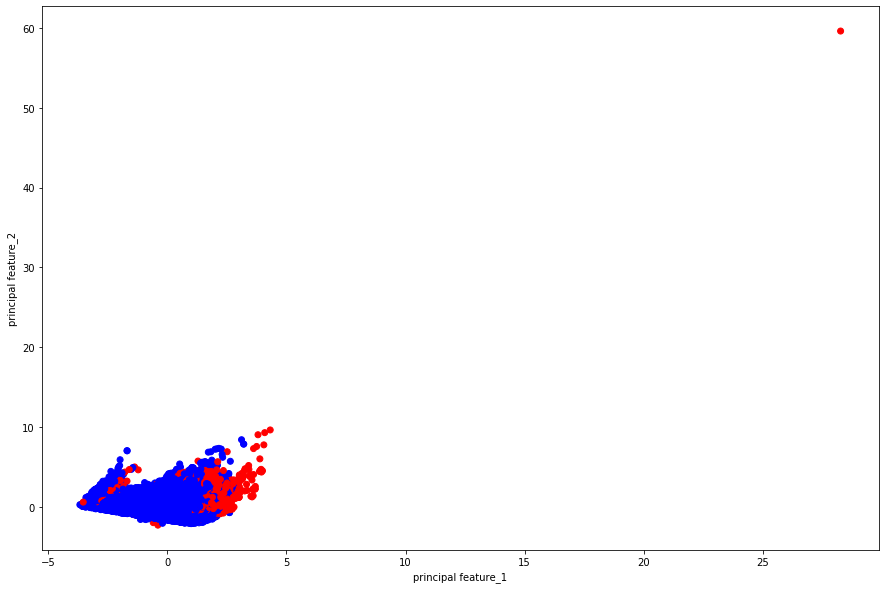

In [25]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(15, 10))
colors = {0:'blue', 1:'red'}
ax.scatter(new_data['principal_feature_1'], new_data['principal_feature_2'], c=new_data["kmeans_anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature_1')
plt.ylabel('principal feature_2')
plt.show()

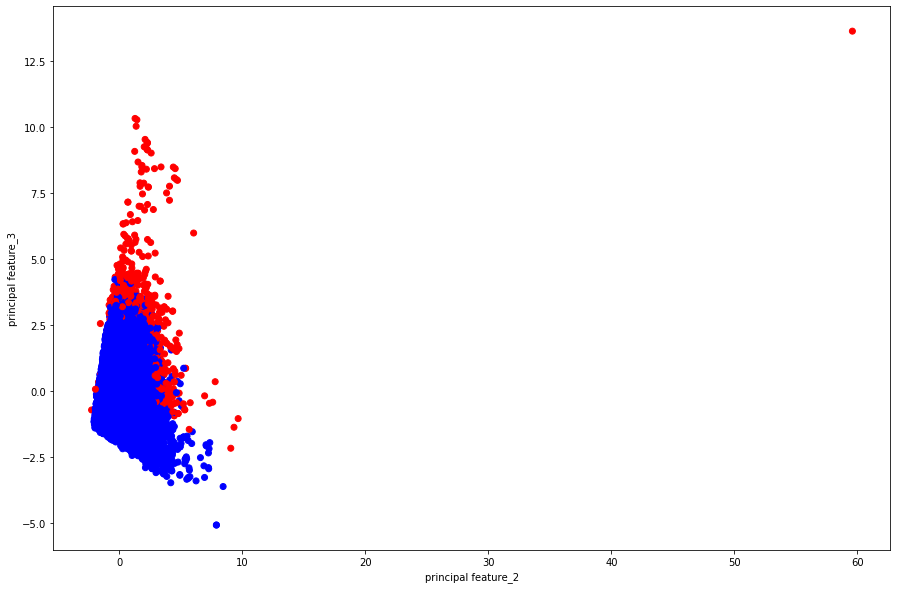

In [26]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(15,10))
colors = {0:'blue', 1:'red'}
ax.scatter(new_data['principal_feature_2'], new_data['principal_feature_3'], c=new_data["kmeans_anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature_2')
plt.ylabel('principal feature_3')
plt.show()

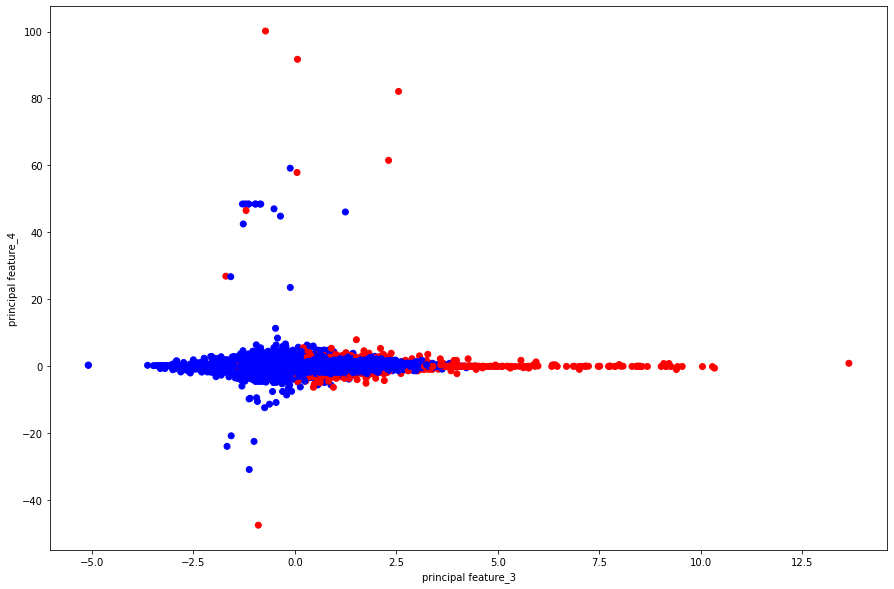

In [27]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(15,10))

colors = {0:'blue', 1:'red'}

ax.scatter(new_data['principal_feature_3'], new_data['principal_feature_4'], c=new_data["kmeans_anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature_3')
plt.ylabel('principal feature_4')
plt.show()

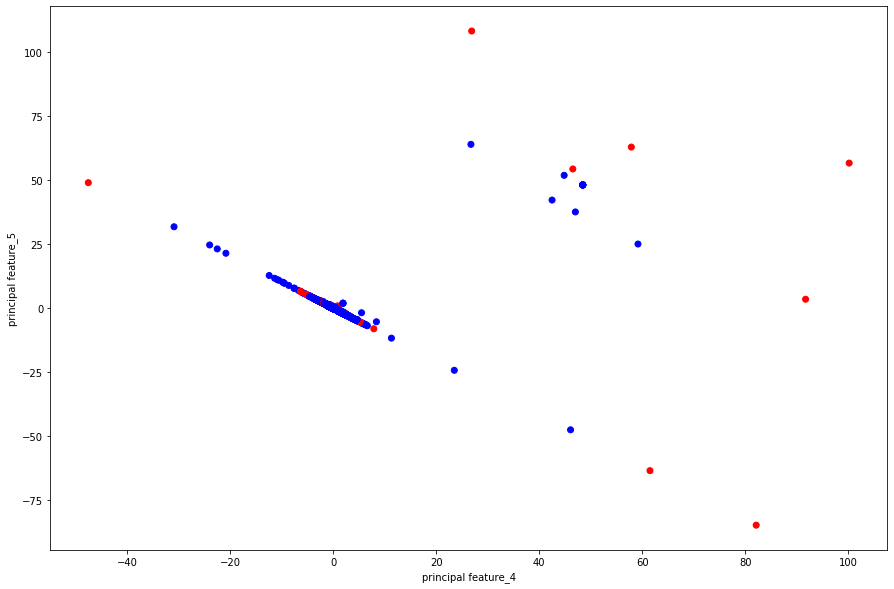

In [28]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots(figsize=(15,10))

colors = {0:'blue', 1:'red'}

ax.scatter(new_data['principal_feature_4'], new_data['principal_feature_5'], c=new_data["kmeans_anomaly"].apply(lambda x: colors[x]))
plt.xlabel('principal feature_4')
plt.ylabel('principal feature_5')
plt.show()

- From the above plots, the anomalous data shown in red can be seen to have behaviours different from the normal ones.

In [29]:
new_data['kmeans_anomaly'].value_counts()

0    98998
1      999
Name: kmeans_anomaly, dtype: int64

- The distance by point anomaly detection returns 999 data points as anomaly while 98999 are identified as normal data points.


### Plot of Anomaly Detected of Price Against Datetime

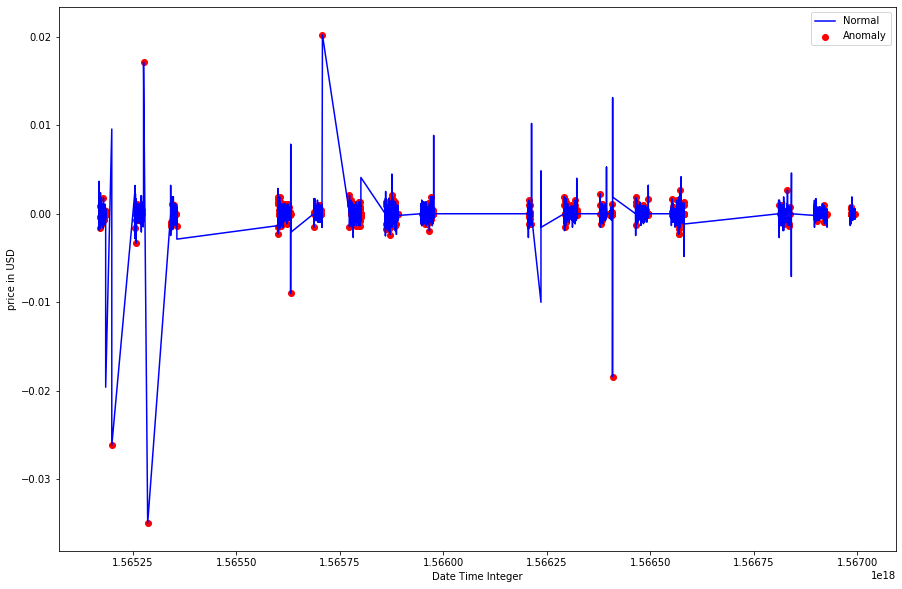

In [30]:
data = data.sort_values('datetime')
new_data['datetime_int'] = data.datetime.astype(np.int64)
fig, ax = plt.subplots(figsize=(15,10))

a = new_data.loc[new_data['kmeans_anomaly'] == 1, ['datetime_int', 'price_log']] #anomaly

ax.plot(new_data['datetime_int'], new_data['price_log'], color='blue', label='Normal')
ax.scatter(a['datetime_int'],a['price_log'], color='red', label='Anomaly')
plt.xlabel('Date Time Integer')
plt.ylabel('price in USD')
plt.legend()
plt.show();

- The red dots indicate datapoints identified as anomalies.
- Most of the red dots are at the highest and lowest points of a spike and sharp fall.

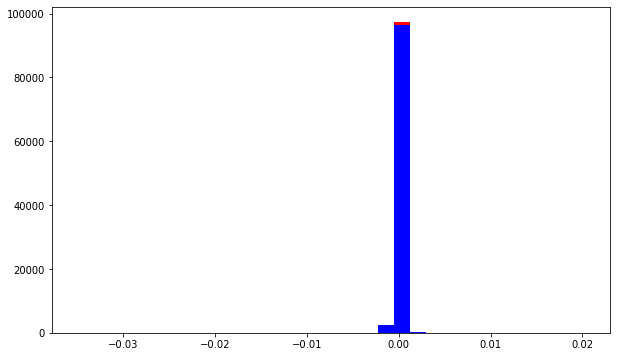

In [31]:
a = new_data.loc[new_data['kmeans_anomaly'] == 0, 'price_log']
b = new_data.loc[new_data['kmeans_anomaly'] == 1, 'price_log']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

# Isolation forest for Anomaly Detection

- Isolation Forest detects anomalies purely based on the fact that anomalies are data points that are few and different. The anomalies isolation is implemented without employing any distance or density measure. This method is fundamentally different from clustering based or distance based algorithms.

In [32]:
isolate_forest = data.drop(data[['datetime']], axis=1)

In [33]:
isolate_forest.dropna(inplace=True)

In [34]:
isolate_forest.head()

,bid_count,bid_quantity,bid,ask,ask_quantity,ask_count,price,volume,price_log
1,1,45,272.75,273.15,11,1,272.40,45,-0.001284
2,1,45,272.75,273.15,11,1,272.25,39,-0.000551
3,1,45,272.75,273.15,11,1,271.75,44,-0.001838
4,2,284,271.75,272.20,60,1,271.75,72,0.000000
5,2,124,271.75,272.15,27,1,271.75,32,0.000000


In [35]:
#scale the data
scaler = StandardScaler()
isolate_forest_scaled = scaler.fit_transform(isolate_forest)

isolate_forest_df = pd.DataFrame(isolate_forest_scaled)

#instatiate the Isolation Forest model and fit on the scaled dataframe
isolate_forest_model = IsolationForest(contamination=outliers_fraction)
isolate_forest_model.fit(isolate_forest_df)

new_data['isolate_anomaly'] = pd.Series(isolate_forest_model.predict(isolate_forest_df))

/home/godwin/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/godwin/.local/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


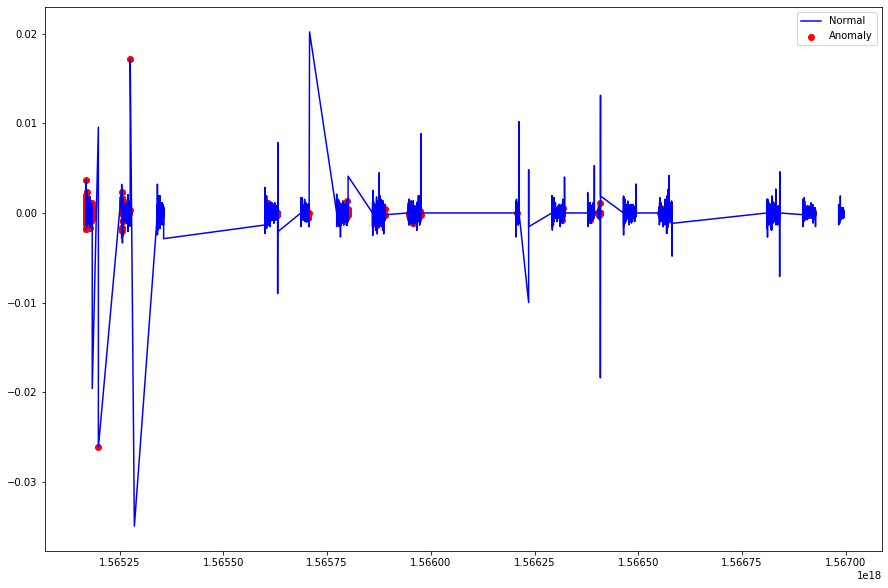

In [36]:
fig, ax = plt.subplots(figsize=(15, 10))

a = new_data.loc[new_data['isolate_anomaly'] == -1, ['datetime_int', 'price_log']]
ax.plot(new_data['datetime_int'], new_data['price_log'], color='blue', label = 'Normal')
ax.scatter(a['datetime_int'], a['price_log'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

- The red dots here also represents the detected anomalies and se see that they are not spread accross multiple time frame.

In [37]:
new_data['isolate_anomaly'].value_counts()

 1    98997
-1     1000
Name: isolate_anomaly, dtype: int64

- 1000 data points are detected as anomalies, one greater than Kmeans.

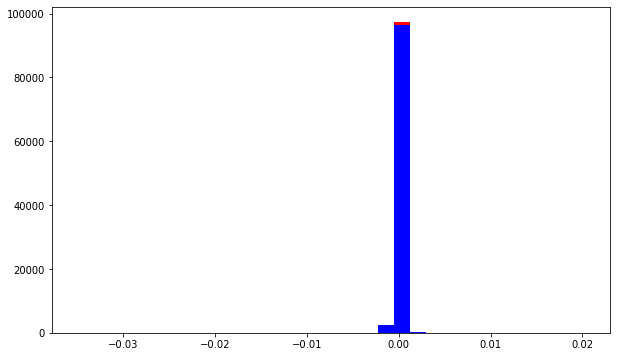

In [38]:
# visualisation of anomaly with avg price repartition
a = new_data.loc[new_data['isolate_anomaly'] == 1, 'price_log']
b = new_data.loc[new_data['isolate_anomaly'] == -1, 'price_log']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

- The stacked hist plot shows that there are more anomalies at the highest prices.

In [39]:
# save the model to disk
filename = 'isolate_forest_model_stat.sav'
pickle.dump(isolate_forest_model, open(filename, 'wb'))

# Support Vector Machine Based Anomaly Detection

- The idea of SVM for anomaly detection is to find a function that is positive for regions with high density of points, and negative for small densities.

- Used the one class support vector.

In [40]:
svm_data = data.drop(data[['datetime']], axis=1)

In [41]:
svm_data.dropna(inplace=True)

In [42]:
# instantiate and fit the standard scaler
svm_scaler = StandardScaler()
svm_data_scaled = svm_scaler.fit_transform(svm_data)
svm_data_df = pd.DataFrame(svm_data_scaled)

#instantiate the model with the parameters nu and rbf kernel and gamma 0.01
svm_model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=0.01)
svm_model.fit(svm_data_df)

#make prediction on the uisolate forest dataframe
new_data['svm_anomaly'] = pd.Series(svm_model.predict(svm_data_df))

In [43]:
new_data['svm_anomaly'].value_counts()

 1    98999
-1      998
Name: svm_anomaly, dtype: int64

- 998 anomalies detected here also.

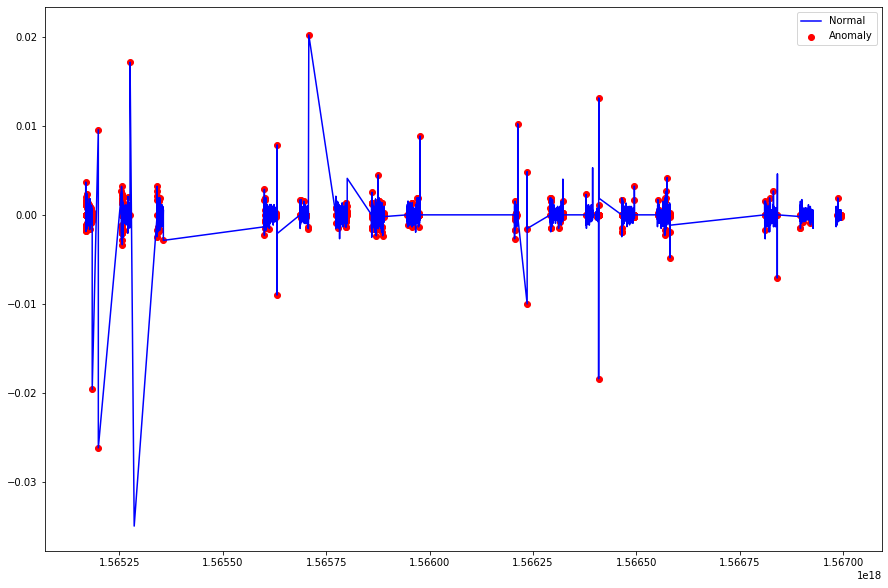

In [44]:
fig, ax = plt.subplots(figsize=(15, 10))

a = new_data.loc[new_data['svm_anomaly'] == -1, ['datetime_int', 'price_log']]

ax.plot(new_data['datetime_int'], new_data['price_log'], color='blue', label = 'Normal')
ax.scatter(a['datetime_int'], a['price_log'], color='red', label = 'Anomaly')
plt.legend()
plt.show()

- Red anomaly dots here are atleast spread accross the time frame.

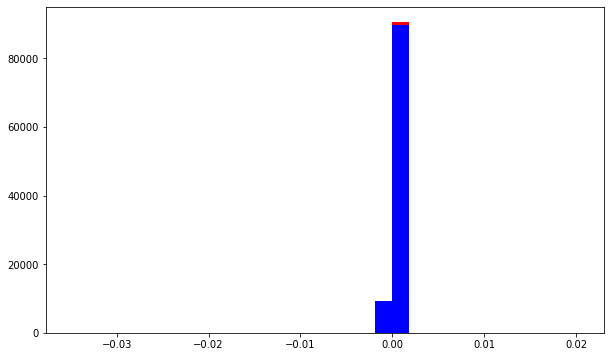

In [45]:
# visualisation of anomaly with avg price repartition
a = new_data.loc[new_data['svm_anomaly'] == 1, 'price_log']
b = new_data.loc[new_data['svm_anomaly'] == -1, 'price_log']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=30, stacked=True, color=['blue', 'red'])
plt.show()

- The datcked histogram also shows this spread.

In [46]:
# save the model to disk
filename = 'oneclasssvm_stat_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))